In [1]:
import numpy as np
import pylab as pl
import datetime

#For the LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# To get the Mars orbit data from the JPL database
from astroquery.jplhorizons import Horizons
from astropy.time import Time

# First, get the Mars data for a 20 year window around 1600

In [2]:
# Query the Mars data for 20 years, in 1 day steps.
#
#      *This will take 15 minutes*

base = datetime.datetime(1600,1,2,20,0,0,0) # Start: 8pm on Jan 2nd 1600
dt = 3 # Get a datapoint every day

date_list = [base + datetime.timedelta(days=x) for x in range(0, 20*365, dt)]
tycho_data = np.zeros((len(date_list),5), dtype = np.float64)

for idx in range(len(date_list)):
    epoch = Time(date_list[idx])
    obj = Horizons('499', id_type='id', location='035', epochs=epoch.jd)
    # see JPL: '499' is the object id for Mars
    # see JPL: '035' is the observer code for Copenhagen ( 12°34'33.3''E, 55°41'12.7''N, 10.2 m )

    eph = obj.ephemerides()
    # eph contains a whole lot of data, like brightness, time of sunrise and set etc. Here we only look at
    # Azimuth, elevation (what Tycho B would have measured) + absolute time

    tycho_data[idx,0] = idx*dt     # time in days
    tycho_data[idx,1] = eph['AZ']  # azimuth in degre
    tycho_data[idx,2] = eph['EL']  # elevation in degree
    tycho_data[idx,3] = eph['DEC'] # declination in degree
    tycho_data[idx,4] = eph['RA']  # Right ascension in degrees

/Users/ms81/venv_keras/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


# Plot the Mars data

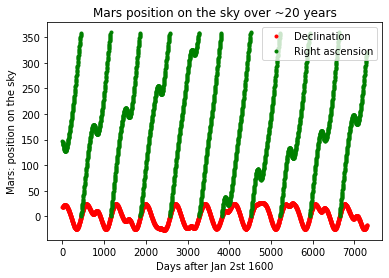

In [4]:
pl.title("Mars position on the sky over ~20 years")
pl.plot(tycho_data[:,0], tycho_data[:,3], 'r.', label = "Declination")
pl.plot(tycho_data[:,0], tycho_data[:,4], 'g.', label = "Right ascension")
pl.legend()
pl.xlabel("Days after Jan 2st 1600")
pl.ylabel("Mars: position on the sky");

# Fit a LSTM to the data

In [90]:
#Some housekeeping, and formatting
np.random.seed(7)
units = 128
batch_size = 1

X, y = tycho_data[:, 0:-1], tycho_data[:, 3] # Lets try declination
y = y/np.max(np.abs(y))                      # rescaled to -1|1
X = X.reshape(X.shape[0], 1, X.shape[1])

In [91]:
# Setting up LSTM
model = Sequential()
model.add(LSTM(units, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (1, 128)                  68096     
_________________________________________________________________
dense_21 (Dense)             (1, 1)                    129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Doing the fit
model.fit(X, y, epochs=20, batch_size=batch_size, verbose=2)

Epoch 1/20
2434/2434 - 2s - loss: 0.3857
Epoch 2/20
2434/2434 - 2s - loss: 0.2936
Epoch 3/20
2434/2434 - 3s - loss: 0.1965
Epoch 4/20
2434/2434 - 2s - loss: 0.1529
Epoch 5/20
2434/2434 - 2s - loss: 0.1427
Epoch 6/20
2434/2434 - 2s - loss: 0.1228
Epoch 7/20
2434/2434 - 2s - loss: 0.1083
Epoch 8/20
2434/2434 - 2s - loss: 0.1080
Epoch 9/20
2434/2434 - 3s - loss: 0.1148
Epoch 10/20
2434/2434 - 2s - loss: 0.1154
Epoch 11/20
2434/2434 - 2s - loss: 0.1102
Epoch 12/20
2434/2434 - 2s - loss: 0.1095
Epoch 13/20
2434/2434 - 2s - loss: 0.1108
Epoch 14/20
2434/2434 - 2s - loss: 0.1090
Epoch 15/20
2434/2434 - 2s - loss: 0.1262
Epoch 16/20
2434/2434 - 2s - loss: 0.0938
Epoch 17/20
2434/2434 - 2s - loss: 0.1085
Epoch 18/20
2434/2434 - 2s - loss: 0.0956
Epoch 19/20
2434/2434 - 2s - loss: 0.1100
Epoch 20/20
2434/2434 - 2s - loss: 0.1008


In [96]:
yhat = model.predict(X, batch_size=batch_size)

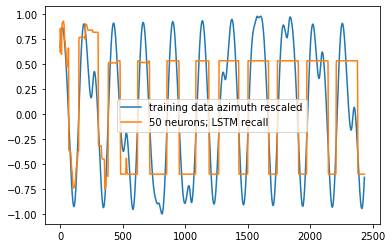

In [97]:
pl.plot(y, label='training data azimuth rescaled')
pl.plot(yhat, label='50 neurons; LSTM recall')
pl.legend()